### Load Data

In [1]:
import pandas as pd

courses_prices = pd.read_csv('./Data/course_prices.csv')
courses = pd.read_csv('./Data/Coursera_courses.csv')
users = pd.read_csv('./Data/Coursera_reviews.csv')
courses_metadata = pd.read_csv('./Data/CourseraDataset-Unclean.csv')
job_skills = pd.read_csv('./Data/job_skills.csv')
job_metadata = pd.read_csv('./Data/linkedin_job_postings.csv')

### Remove Duplicate Courses

In [2]:
courses_metadata.rename(columns={'Course Title': 'name'}, inplace = True)
courses_metadata.drop_duplicates(subset=['name'], inplace=True)

### Remove Duplicate Reviews

In [3]:
users.drop_duplicates(subset=['reviews', 'reviewers', 'course_id'], inplace=True)

### Handle Null Values

In [4]:
#print(job_skills.isnull().sum())
#print(courses.isnull().sum())
#print(users.isnull().sum())
job_skills = job_skills.dropna(subset=['job_skills'])

### Merge Courses with Users by course_id

In [5]:
temp = pd.merge(users, courses, on="course_id", how="inner")
#temp.head()

### Remove non-ASCII values in 'name' columns in dataset

In [6]:
def clean_string(value):
    return value.encode('ascii', 'ignore').decode('ascii')

temp['name'] = temp['name'].apply(clean_string)
temp['institution'] = temp['institution'].apply(clean_string)
temp['reviewers'] = temp['reviewers'].apply(clean_string)
courses_metadata['name'] = courses_metadata['name'].apply(clean_string)
courses_prices['name'] = courses_prices['name'].apply(clean_string)
courses_prices['institution'] = courses_prices['institution'].apply(clean_string)

### Merge Additional Metadata with Temp dataset

In [7]:
courses_data = pd.merge(temp, courses_metadata, on="name", how="inner")

#courses_data.head()

### Filter Essential Columns in Courses Data

In [8]:
final_courses = courses_data[['reviews', 'reviewers', 'rating', 'name', 'institution', 'Rating', 'Level', 'Duration', 'Review', 'Skill gain', 'Instructor']]
final_courses = final_courses.rename(columns={ 'Rating': 'Overall Ratings', 'Review': 'Num of Reviews'})
final_courses['Skill gain'] = final_courses['Skill gain'].str.replace("'", "")
#final_courses.head()

### Merge Datasets regarding Jobs

In [9]:
jobs_data = pd.merge(job_skills, job_metadata, on="job_link", how="inner")
#jobs_data.head()

### Filter Essential Columns in Jobs Data

In [10]:
final_jobs = jobs_data[['job_skills', 'job_title', 'search_position', 'job_level']]
#final_jobs.head()
#unique_values = final_jobs['search_position'].unique()
#print(unique_values.tolist())

### Preprocess 
1) Prices
2) Remove "By' from reviewer
3) Fill in null values in level
4) get the number in duration, 
5) get the number in review, 
6) remove the list of skill gain
7) remove the list of instructor


In [11]:
final_courses['reviewers'] = final_courses['reviewers'].apply(lambda x: x[3:])
final_courses['Level'].fillna('None', inplace=True)
final_courses['Duration'] = final_courses['Duration'].str.extract('(\d+)').astype(int)
final_courses['Num of Reviews'] = final_courses['Num of Reviews'].str.extract('(\d+)').astype(int)
final_courses['Skill gain'] = final_courses['Skill gain'].apply(lambda x: x[1:-1])
final_courses['Instructor'] = final_courses['Instructor'].apply(lambda x: x[2:-2])
final_courses['Skill gain'] = final_courses['Skill gain'].replace('', 'No Specific Skills')

# final_courses.head()

### Demean Ratings

In [12]:
reviewer_average_rating = final_courses.groupby('reviewers')['rating'].transform('mean')
final_courses['Demeaned Rating'] = final_courses['rating'] - reviewer_average_rating
# final_courses.head()

### Adding Price Column to Courses Data

In [13]:
final_courses = pd.merge(final_courses, courses_prices, on=['institution', 'name'], how='inner')
# print(final_courses.isnull().sum())
# print(final_courses.head())

### Remove empty Reviewers data

In [14]:
final_courses = final_courses[final_courses['reviewers'] != '']

### Adding Popularity to Courses Data

In [15]:
final_courses['Popularity'] = final_courses['Overall Ratings'] * final_courses['Num of Reviews']
# final_courses.head()

## EDA

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Histogram of Number of Ratings given by each Reviewer

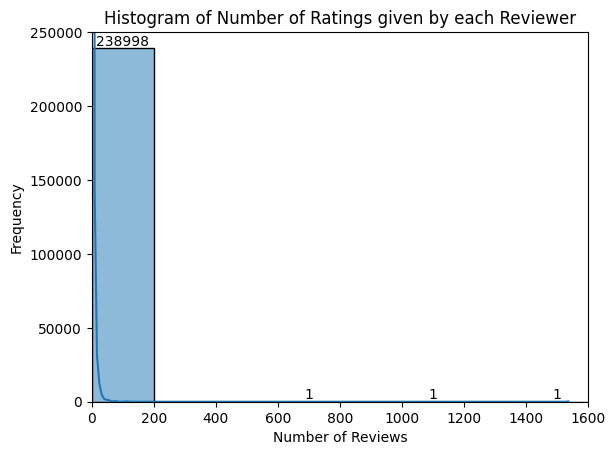

In [17]:
unique_reviewers = final_courses.groupby('reviewers').size().reset_index(name='count_of_reviews')

bin_interval = 200
bin_edges = np.arange(0, unique_reviewers['count_of_reviews'].max() + bin_interval, bin_interval)

ax = sns.histplot(data=unique_reviewers, x='count_of_reviews', bins=bin_edges, kde=True, edgecolor='black', stat='count')

for bin in ax.patches:
    if bin.get_height() > 0:
        ax.annotate(format(bin.get_height(), '.0f'), 
                    (bin.get_x() + bin.get_width() / 2., bin.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 5), 
                    textcoords = 'offset points')
    
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Ratings given by each Reviewer')
plt.xlim(0, 1600)
plt.ylim(0, 250000)
plt.show()

### Explore Number of Reviews > 600 and Handle it 

In [18]:
high_review_count = unique_reviewers[unique_reviewers['count_of_reviews'] > 600]
print(high_review_count)
unique_reviewers = unique_reviewers[unique_reviewers['count_of_reviews'] < 600]

       reviewers  count_of_reviews
7                              772
8                             1019
49593  Deleted A              1537


### Remove Reviewers who have > 600 Number of Reviews from final_courses

In [19]:
final_courses = final_courses[~final_courses['reviewers'].isin(high_review_count['reviewers'])]

### Plot New Histogram of Number of Ratings given by each Reviewer

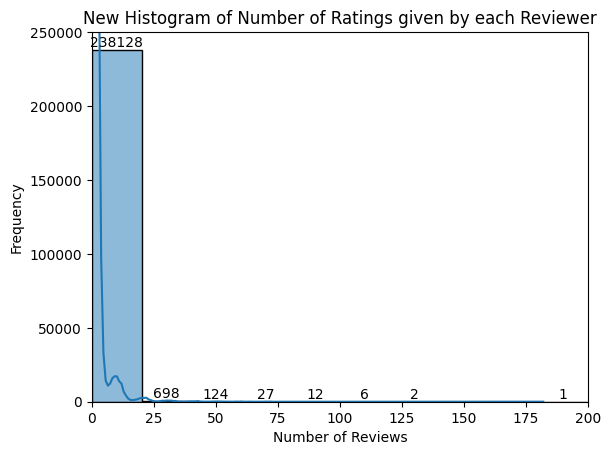

In [20]:
bin_interval = 20
bin_edges = np.arange(0, unique_reviewers['count_of_reviews'].max() + bin_interval, bin_interval)

ax = sns.histplot(data=unique_reviewers, x='count_of_reviews', bins=bin_edges, kde=True, edgecolor='black', stat='count')

for bin in ax.patches:
    if bin.get_height() > 0:
        ax.annotate(format(bin.get_height(), '.0f'), 
                    (bin.get_x() + bin.get_width() / 2., bin.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 5), 
                    textcoords = 'offset points')
    
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.title('New Histogram of Number of Ratings given by each Reviewer')
plt.xlim(0, 200)
plt.ylim(0, 250000)
plt.show()

In [21]:
final_courses.describe().round(2)

,rating,Overall Ratings,Duration,Num of Reviews,Demeaned Rating,Fee,Popularity
count,411181.00,411181.00,411181.00,411181.00,411181.00,411181.00,411181.00
mean,4.69,4.75,19.76,45.55,-0.00,50.94,217.28
std,0.71,0.12,11.97,105.06,0.46,12.99,496.38
min,1.00,3.90,2.00,1.00,-3.84,29.00,4.20
25%,5.00,4.70,11.00,4.00,0.00,49.00,19.60
50%,5.00,4.80,18.00,12.00,0.00,49.00,57.60
75%,5.00,4.80,26.00,37.00,0.00,49.00,181.30
max,5.00,4.90,127.00,980.00,3.00,777.00,4704.00


In [22]:
print("Count of datapoints: ", final_courses.shape)
print("Count of Unique Reviewers: ", final_courses['reviewers'].nunique())
print("Count of Unique Courses: ", final_courses['name'].nunique())

Count of datapoints:  (411181, 14)
Count of Unique Reviewers:  238998
Count of Unique Courses:  485


### Histogram of Popularity of each Course

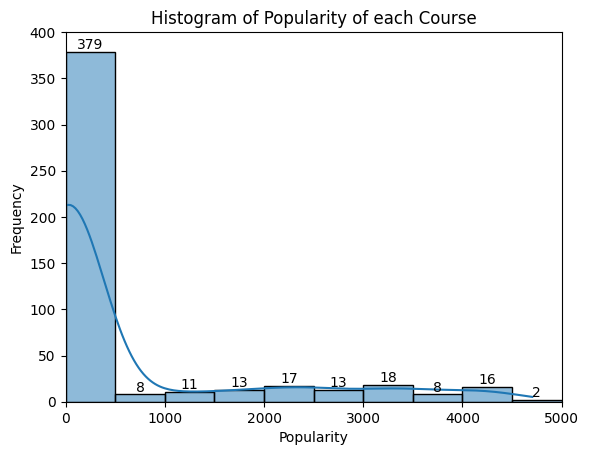

In [23]:
grouped_courses = final_courses.drop_duplicates(subset=['institution', 'name'])

bin_interval = 500
bin_edges = np.arange(0, grouped_courses['Popularity'].max() + bin_interval, bin_interval)

ax = sns.histplot(data=grouped_courses, x='Popularity', bins=bin_edges, kde=True, edgecolor='black', stat='count')

for bin in ax.patches:
    if bin.get_height() > 0:
        ax.annotate(format(bin.get_height(), '.0f'), 
                    (bin.get_x() + bin.get_width() / 2., bin.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 5), 
                    textcoords = 'offset points')
    
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.title('Histogram of Popularity of each Course')
plt.xlim(0, 5000)
plt.ylim(0, 400)

plt.show()


### Histogram of Count of Ratings given for each Course

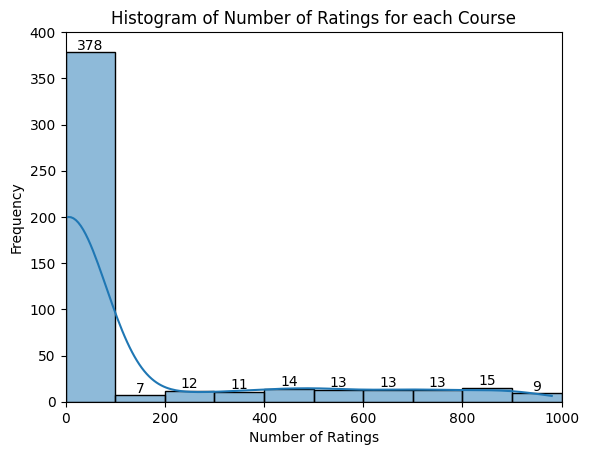

In [24]:
grouped_courses = final_courses.drop_duplicates(subset=['institution', 'name'])

bin_interval = 100
bin_edges = np.arange(0, grouped_courses['Num of Reviews'].max() + bin_interval, bin_interval)

ax = sns.histplot(data=grouped_courses, x='Num of Reviews', bins=bin_edges, kde=True, edgecolor='black', stat='count')

for bin in ax.patches:
    if bin.get_height() > 0:
        ax.annotate(format(bin.get_height(), '.0f'), 
                    (bin.get_x() + bin.get_width() / 2., bin.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 5), 
                    textcoords = 'offset points')
    
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Ratings for each Course')
plt.xlim(0, 1000)
plt.ylim(0, 400)

plt.show()

### Histogram of Overall Ratings of each Course


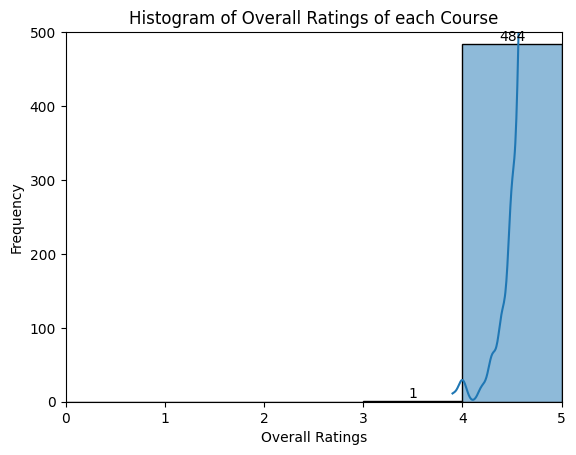

In [25]:
grouped_courses = final_courses.drop_duplicates(subset=['institution', 'name'])

bin_interval = 1
bin_edges = np.arange(0, grouped_courses['Overall Ratings'].max() + bin_interval, bin_interval)

ax = sns.histplot(data=grouped_courses, x='Overall Ratings', bins=bin_edges, kde=True, edgecolor='black', stat='count')

for bin in ax.patches:
    if bin.get_height() > 0:
        ax.annotate(format(bin.get_height(), '.0f'), 
                    (bin.get_x() + bin.get_width() / 2., bin.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 5), 
                    textcoords = 'offset points')
    
plt.xlabel('Overall Ratings')
plt.ylabel('Frequency')
plt.title('Histogram of Overall Ratings of each Course')
plt.xlim(0, 5)
plt.ylim(0, 500)
plt.show()

### Histogram of Ratings given by Reviewers

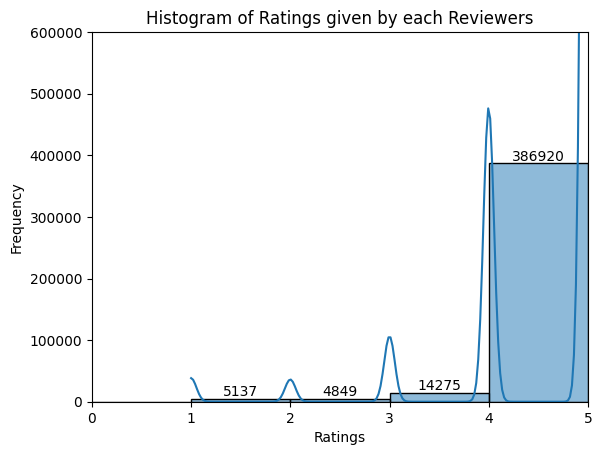

In [26]:
bin_interval = 1
bin_edges = np.arange(0, final_courses['rating'].max() + bin_interval, bin_interval)

ax = sns.histplot(data=final_courses, x='rating', bins=bin_edges, kde=True, edgecolor='black', stat='count')

for bin in ax.patches:
    if bin.get_height() > 0:
        ax.annotate(format(bin.get_height(), '.0f'), 
                    (bin.get_x() + bin.get_width() / 2., bin.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 5), 
                    textcoords = 'offset points')
    
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Histogram of Ratings given by each Reviewers')
plt.xlim(0, 5)
plt.ylim(0, 600000)
plt.show()

### Conclusion
1. Histogram of Overall Ratings for each Course and Histogram of Ratings given by each Reviewer is left skewed, implying that reviewers usually leave positive ratings. 
2. Histogram of Number of Ratings of each Course is right skewed, implying the possibility that not many reviewers would leave ratings. 

Overall, reviewers who leave a rating gave it a high score. There is a possibility that reviewers who are unhappy tend to not leave a rating. 

### Implications
1. It is hard to decipher what reviewers do not like since we do not have data regarding what they gave bad ratings for. 

### Current Solution
1. Use a demeaned rating where a demeaned rating > 0 implies that reviewers "like" the course while a demeaned rating <0 implies that reviewers "less like" the course. 